In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import PIL.Image
if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
    PIL.Image.Resampling = PIL.Image
from torch.utils.data import DataLoader, Dataset


In [2]:
import os
root='paintings/data/'
data={}
for i in os.listdir(root):
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i
data=pd.DataFrame(data.items(),columns=['path','class_'])
data=data.sample(frac=1)
data


,path,class_
746,paintings/data/Landscape/553bff2b-1f15-4e33-91bd-83866ed5e7e4.jpg,Landscape
1593,paintings/data/Surrealist/0de3aaf3-1f44-4586-b4ed-51cf666d9dbd.jpg,Surrealist
1642,paintings/data/Surrealist/3b69b0af-fdbd-4491-8b14-1d8bfab6dbcc.jpg,Surrealist
729,paintings/data/Landscape/34fa4525-3866-4ba8-8d61-8323ce734de4.jpg,Landscape
593,paintings/data/Impressionist/704f279a-0883-43f0-95ce-5ac9b161f453.jpg,Impressionist
...,...,...
517,paintings/data/Impressionist/16d3801b-6cc8-443c-997c-2f52af028ed4.jpg,Impressionist
1097,paintings/data/Portrait/458a83de-85b9-48c4-96cb-8c5373c0ce15.jpg,Portrait
163,paintings/data/Cubist/07fe0dac-e2fb-4d58-b8e0-0dfa5146c125.jpg,Cubist
805,paintings/data/Landscape/b1a3679b-3605-4940-ab3a-a5a8acb59a10.jpg,Landscape


In [3]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,                        # get_image_files returns a list of all images in that path recursively by default
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # getting 90-10 train-validation split
    get_y=parent_label,                               # taking the folder name as labels
    item_tfms=Resize(128))   
dataloader=dblock.dataloaders(root, bs=8)

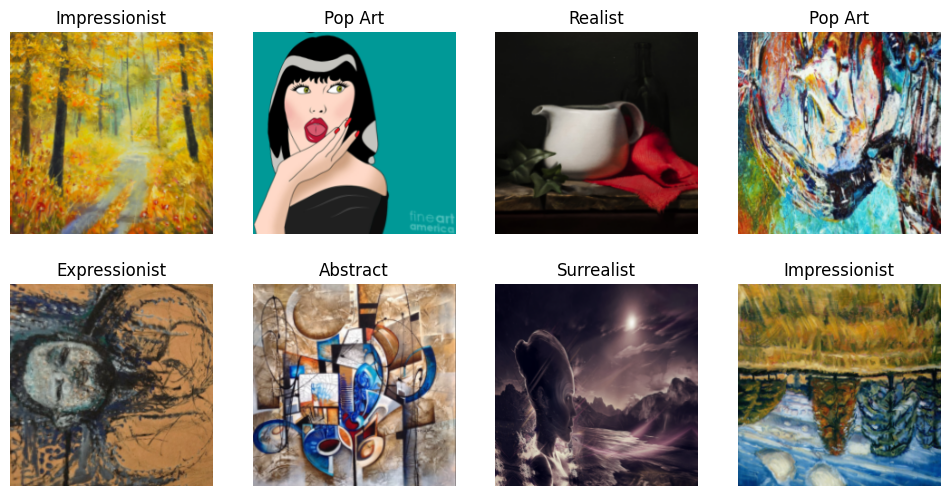

In [4]:
dblock = dblock.new(item_tfms=Resize(224, ResizeMethod.Squish), batch_tfms=aug_transforms(do_flip=True,
                                                                                         flip_vert=True,
                                                                                          max_rotate=10,
                                                                                          max_lighting=0.1,
                                                                                         )) 
dls = dblock.dataloaders(root)
dls.train.show_batch(max_n=8, nrows=2)


In [5]:
model = cnn_learner(dls, densenet201, metrics=[error_rate,accuracy])

/home/jadid/.local/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/jadid/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jadid/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model.load('modelv1')

In [7]:
cleaner = ImageClassifierCleaner(model)
cleaner 

In [9]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()                                   
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), f"{root}/{cat}")